In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [200]:
path = '09.01.16/Pos0000'
fluo = np.fromfile(os.path.join(path,'fluo.np'))
mxll = np.fromfile(os.path.join(path,'max_ll.np'))
pos = np.fromfile(os.path.join(path,'pos.np'))

nt = 49
gx,gy = int(600/32),int(960/32)
startframe = 50
step = 1
print(gx*gy*3*nt)
fluo = fluo.reshape(gx,gy,nt,3)
mxll = mxll.reshape(gx,gy,nt)
pos = pos.reshape(gx,gy,nt,2)

79380


In [201]:
print(fluo.shape)





(18, 30, 49, 3)


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


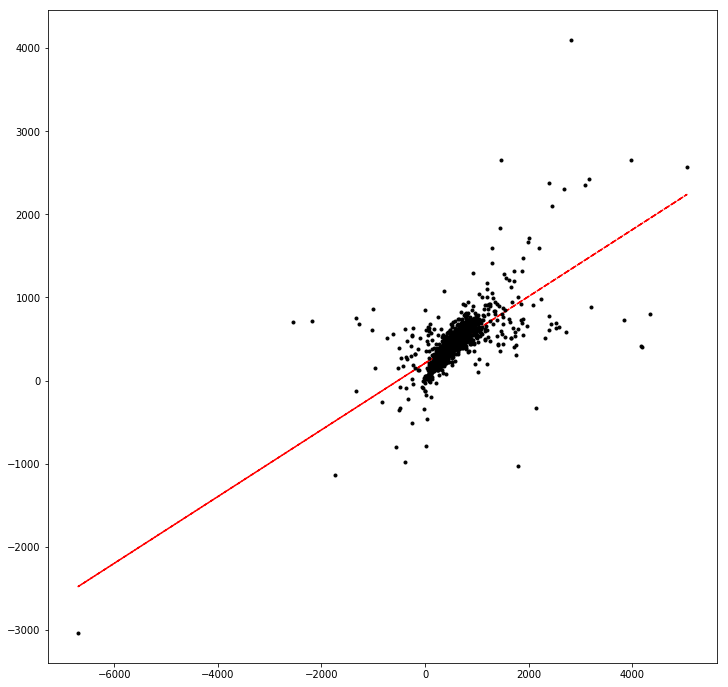

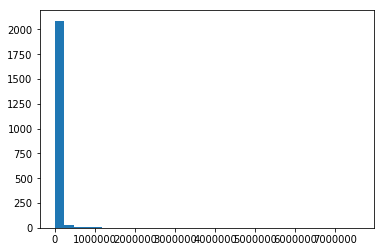

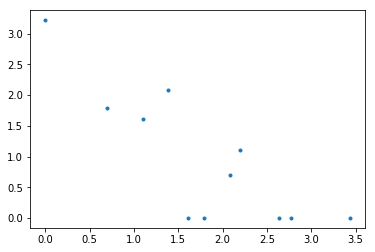

In [205]:
plt.figure(figsize=(12,12))
rfluo = fluo.reshape((gx*gy,nt,3))
drfluo = -np.diff(fluo.reshape((gx*gy,nt,3)), axis=1)
drfluo = drfluo#.ravel()
drfluo0 = drfluo[:,:,0]
drfluo0 = drfluo0[rfluo[:,1:,0]>5000]
drfluo1 = drfluo[:,:,1]
drfluo1 = drfluo1[rfluo[:,1:,0]>5000]

mfluo = np.mean(rfluo,axis=0)
#x,y = rfluo[:,:,0].ravel(), rfluo[:,:,1].ravel()
#_ = plt.plot(x,y, 'k.')
#k,m = np.polyfit(x, y, 1)
#plt.plot(x, k*x + m, 'r--')


#_ = plt.plot(x, y, 'r.')

x = drfluo0
y = drfluo1
k,m = np.polyfit(x, y, 1)

plt.plot(x, k*x + m, 'r--')
plt.plot(x,y,'k.')

plt.figure()
n,bins,_ = plt.hist((y-k*x-m)**2, bins=32)
x = np.arange(32)
plt.figure()
plt.plot(np.log(x),np.log(n), '.')

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


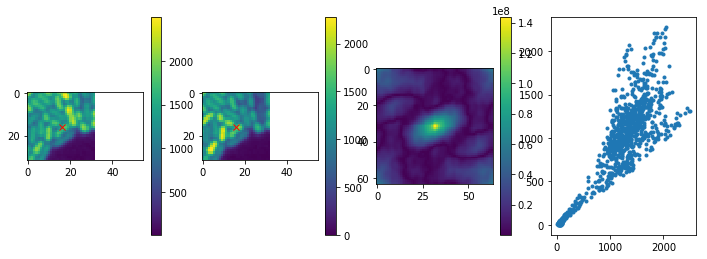

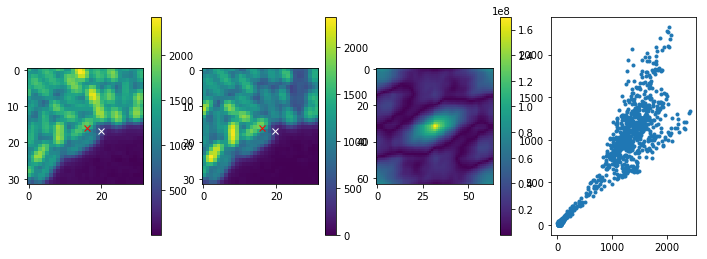

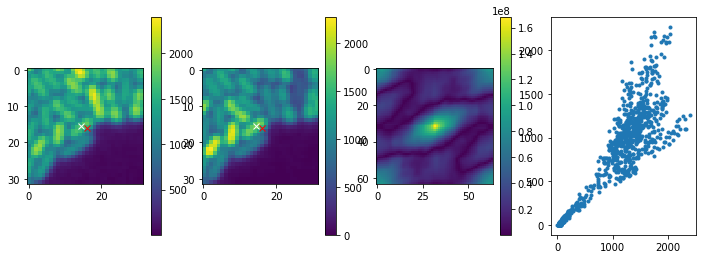

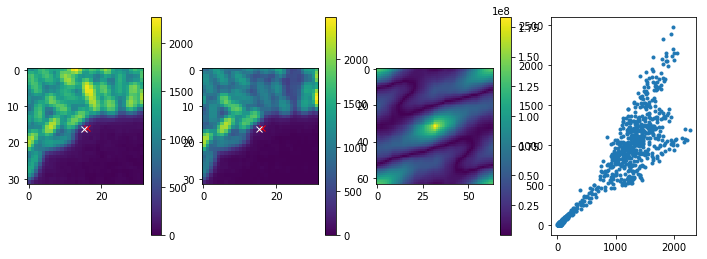

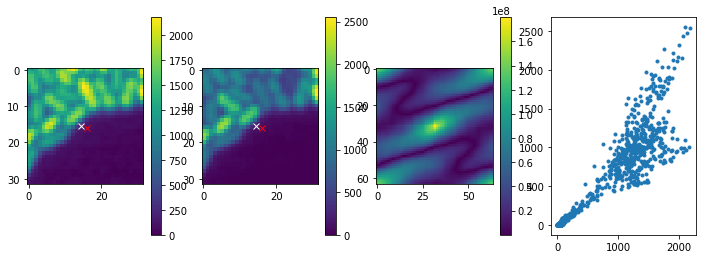

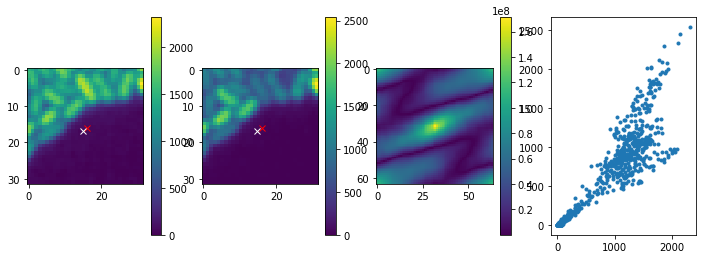

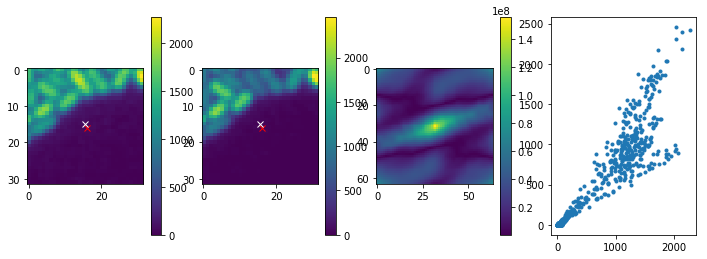

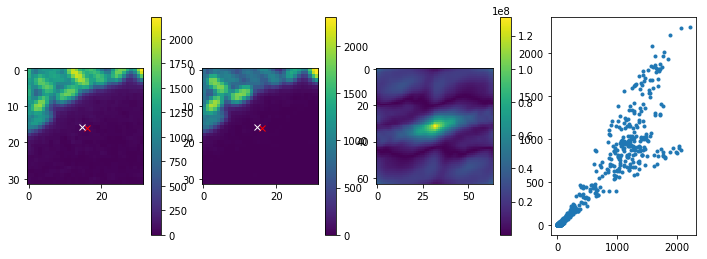

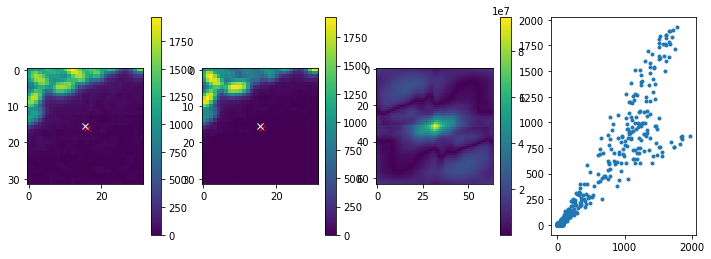

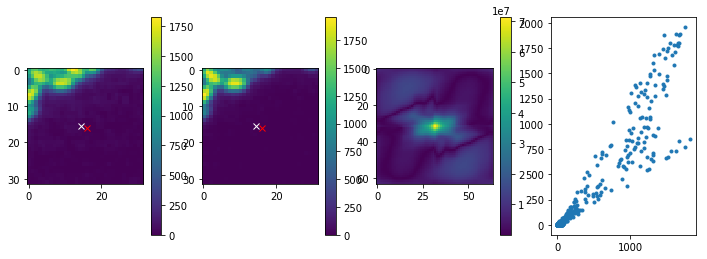

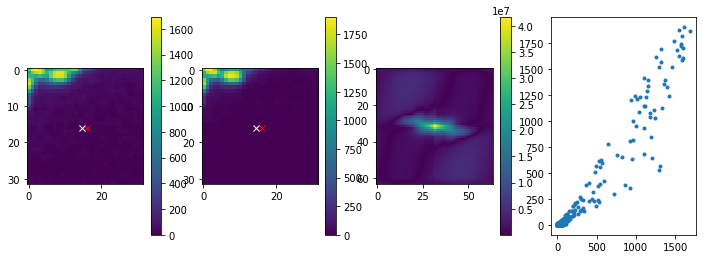

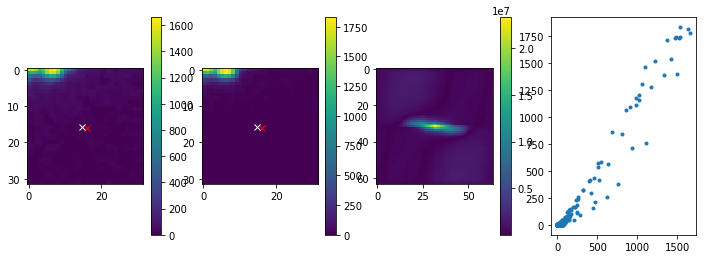

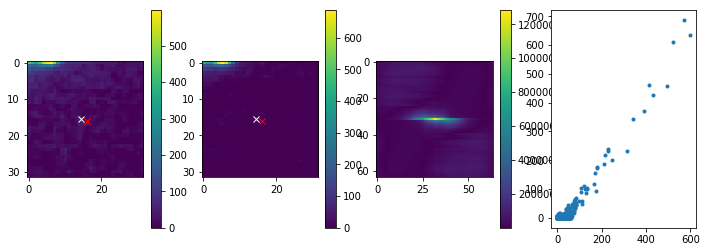

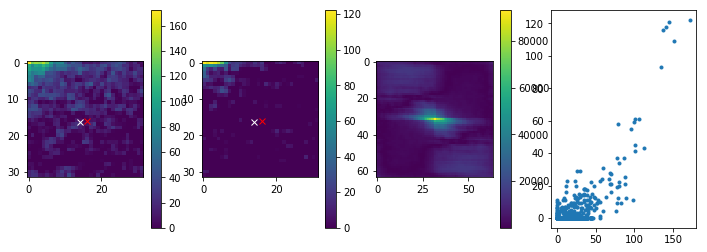

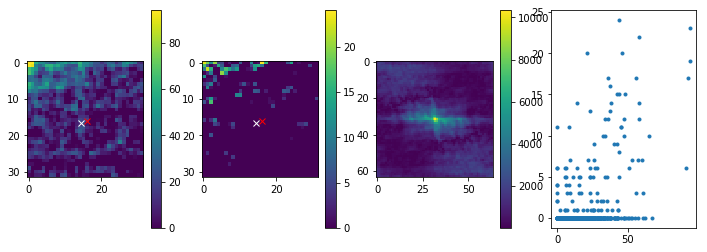

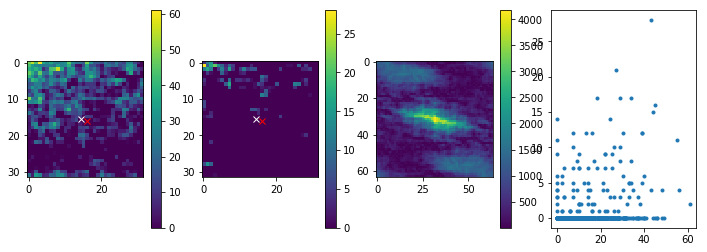

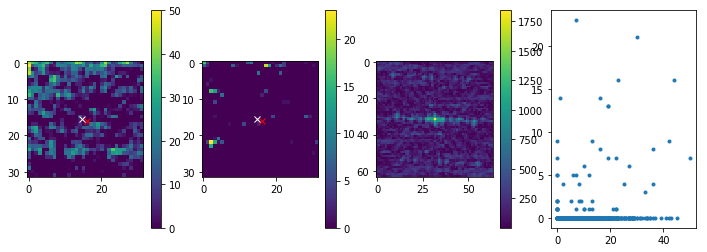

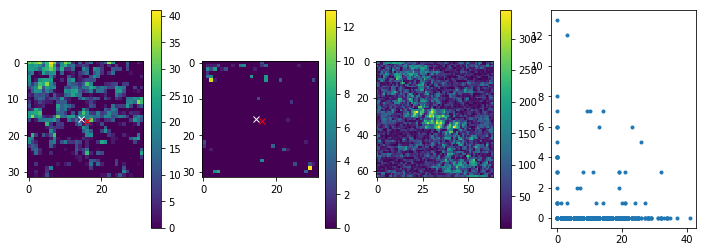

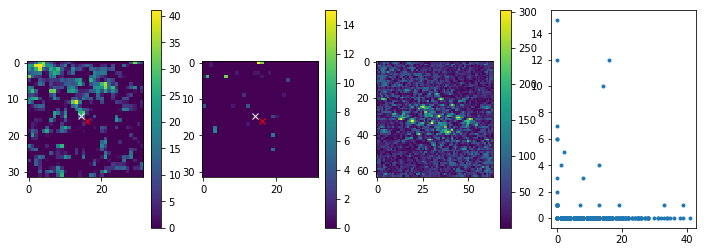

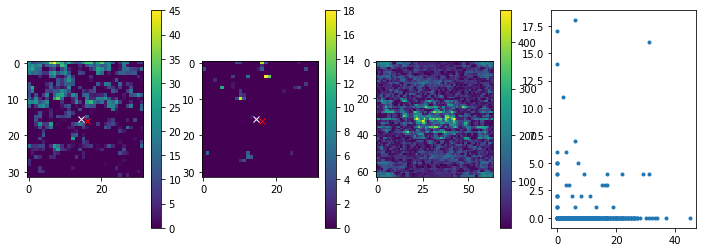

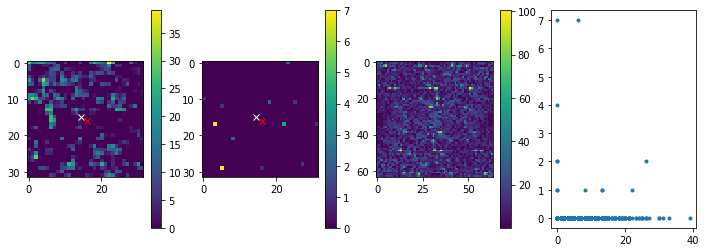

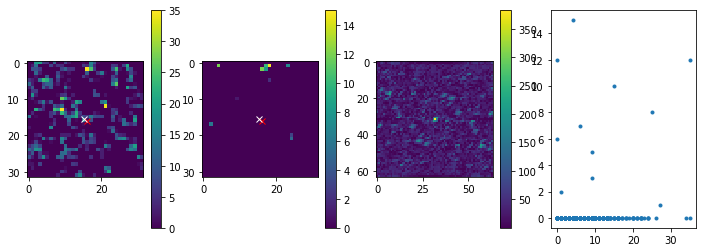

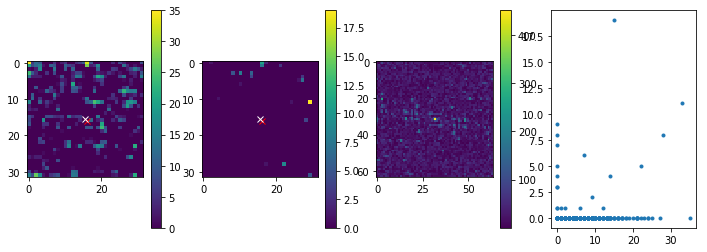

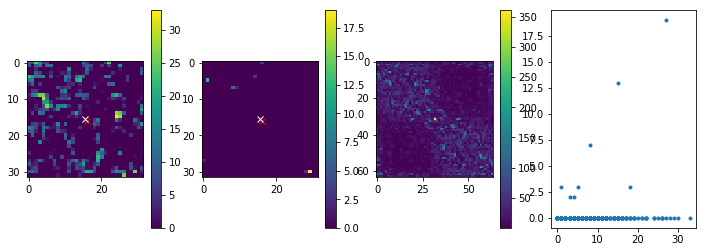

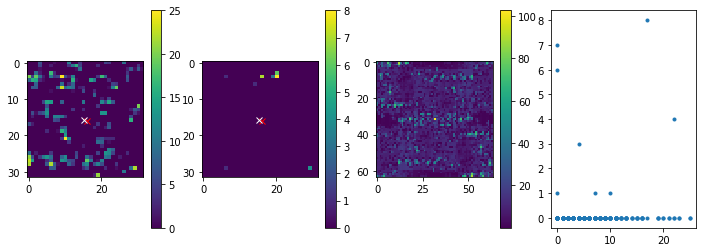

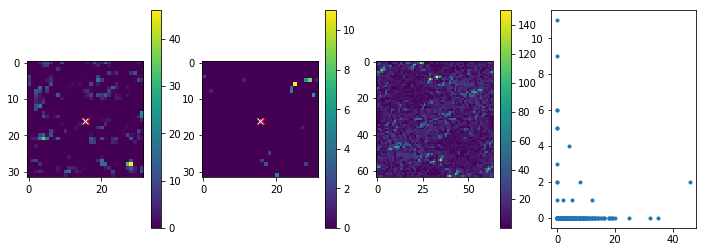

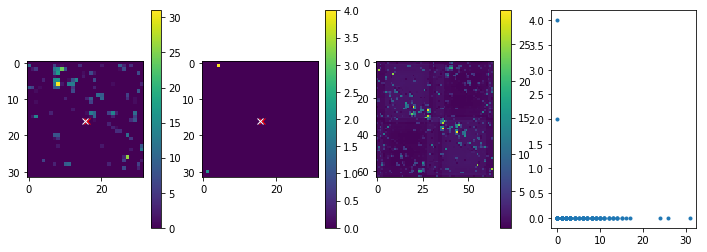

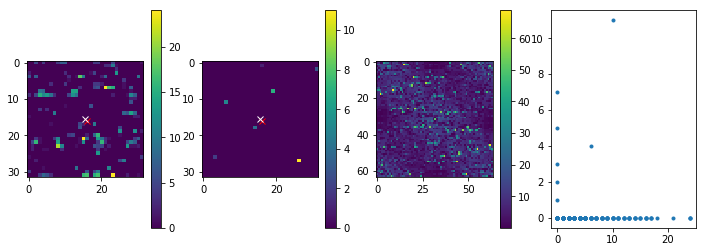

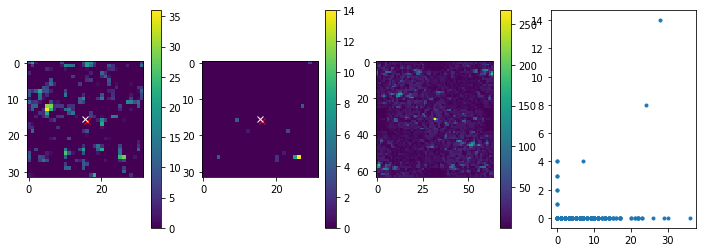

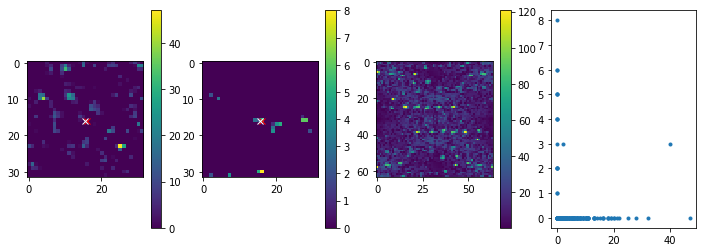

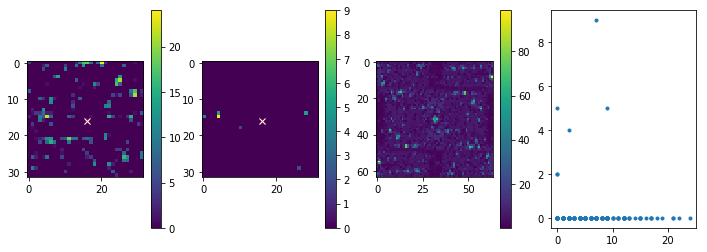

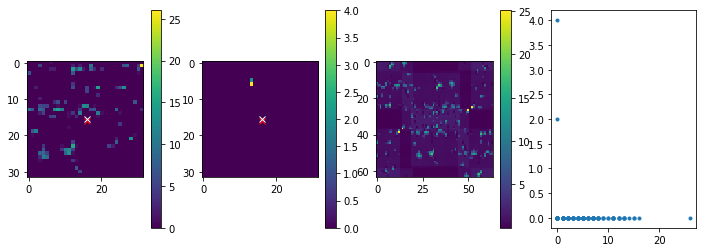

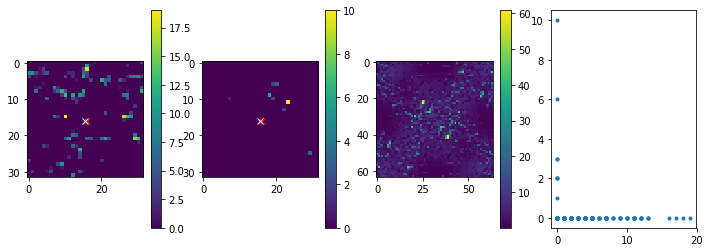

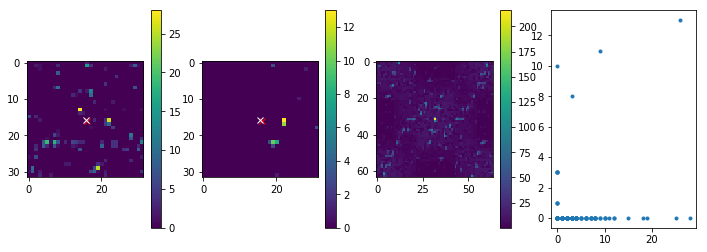

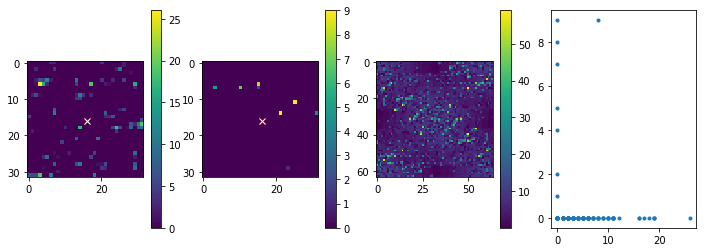

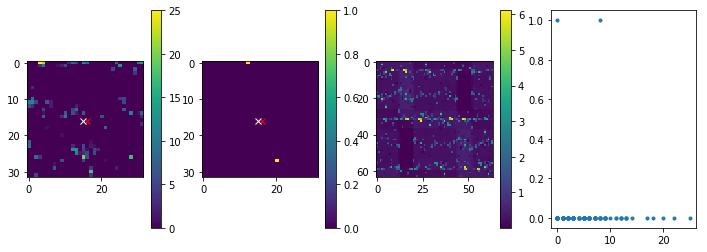

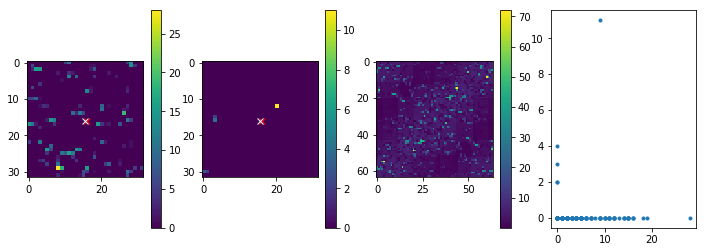

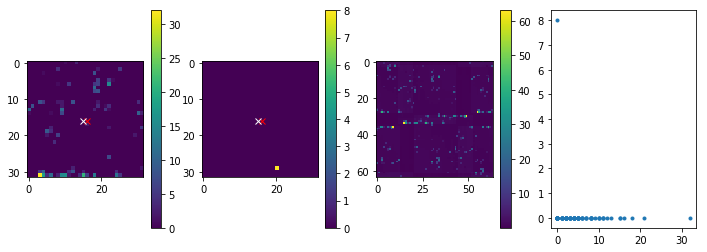

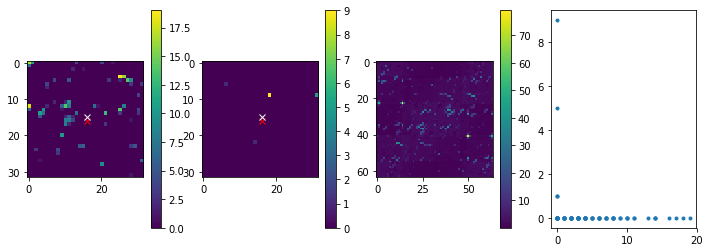

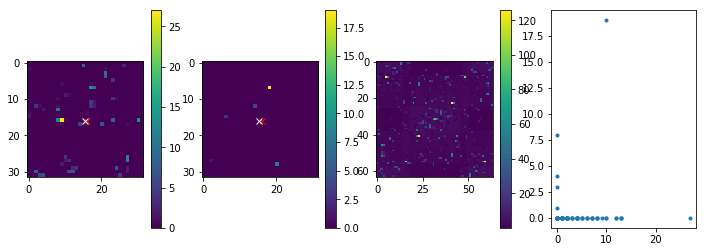

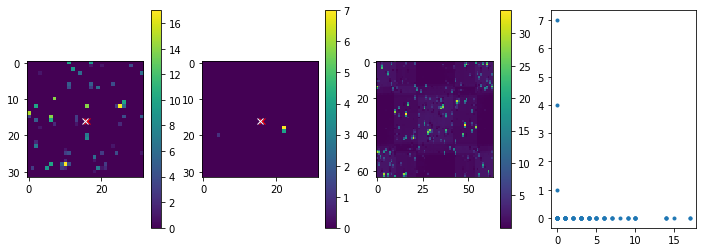

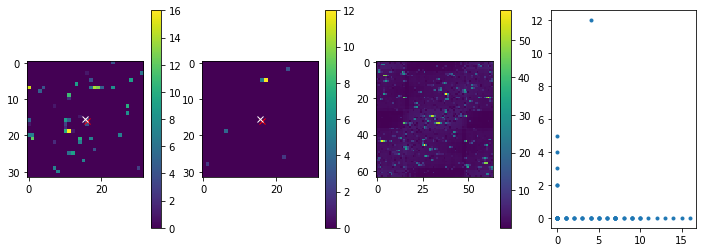

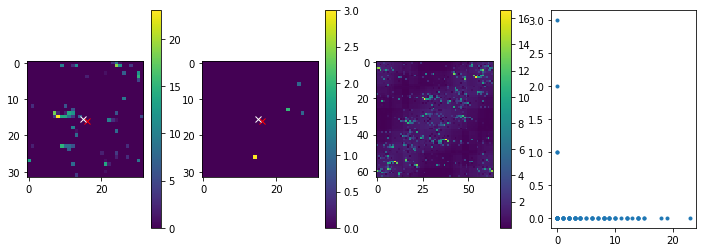

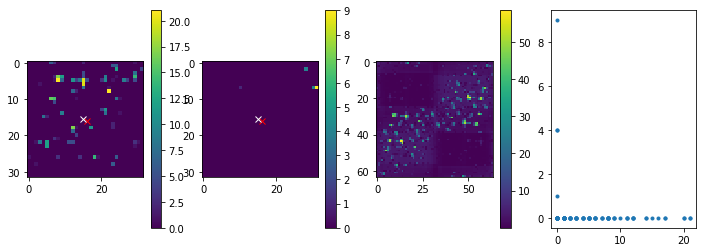

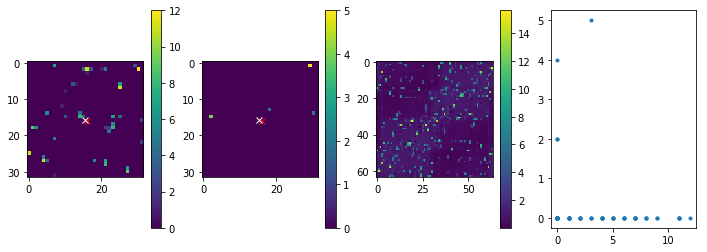

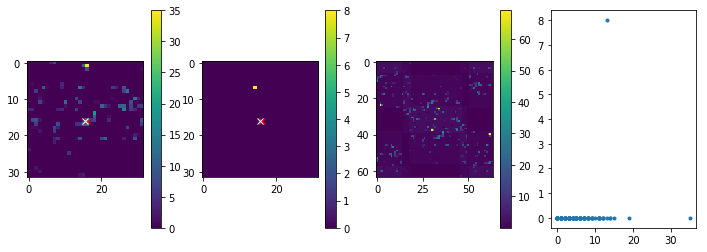

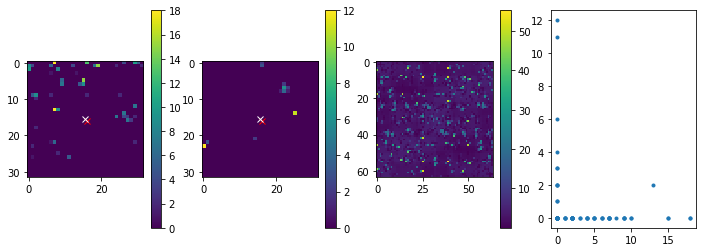

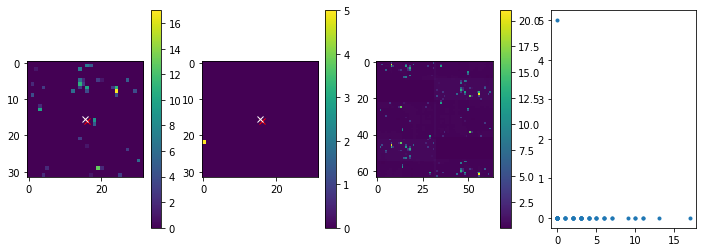

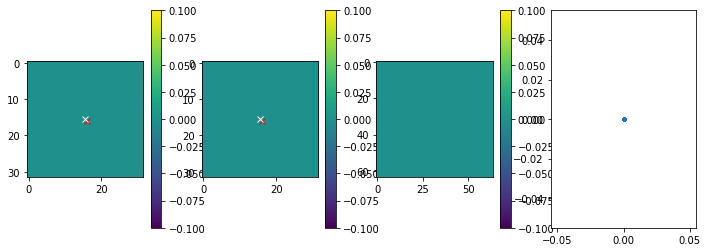

In [204]:
## import skimage
from skimage.io import imread
from skimage.filters import gaussian
from infotracking import infotheory
from numpy.fft import fft2,ifft2,fftshift
%matplotlib inline
fname = os.path.join(path,'aligned_Frame%04dStep%04d.tiff')

#plt.figure(figsize=(12,12))
#plt.imshow()
ix,iy = 14,18
cim = np.zeros((32,32,3))
roi1 = np.zeros((32,32,nt))
roi2 = np.zeros((32,32,nt))
for t in range(0,nt-1,1):
    im1 = imread(fname%(0, startframe+(nt-t)*step))
    im2 = imread(fname%(2, startframe+(nt-t)*step))
    px = int(pos[ix,iy,nt-1-t,0])
    py = int(pos[ix,iy,nt-1-t,1])
    sim1 = im1[px:px+32,py:py+32]
    sim2 = im2[px:px+32,py:py+32]
    roi1[:,:,t] = sim1
    roi2[:,:,t] = sim2

mi = np.zeros((nt,))
hy = np.zeros((nt,))
g = np.zeros((nt,))

I = np.zeros((32,32),dtype=np.complex)
for t in range(0,nt):
    sim1 = roi1[:,:,t]# - roi1[:,:,t-1]
    sim2 = roi2[:,:,t]# - roi2[:,:,t-1]
    
    C = np.cov(np.array([sim1.ravel(), sim2.ravel()]))
    g[t] = C[0,1]
    #print(C)
    
    fsim1 = fftshift(fft2(sim1-np.mean(sim1),s=(64,64))).real
    fsim2 = fftshift(fft2(sim2-np.mean(sim2),s=(64,64))).real

    hgram2d, xedges, yedges = np.histogram2d( sim1.ravel(), \
                                            sim2.ravel(), \
                                            bins=32, range=[[0,2**16],[0,2**16]])

    mi[t] = np.cov(sim1.ravel(),sim2.ravel())[1,0] #infotheory.conditional_entropy(hgram2d, ax=1)
    hgram, edges = np.histogram( sim1.ravel(), \
                                            bins=32)

    hy[t] = infotheory.entropy(hgram)
    
    #plt.subplot(1,3,1)
    #plt.imshow(sim1)
    #plt.plot(32,32,'rx')
    #plt.colorbar()
    #plt.subplot(1,3,2)
    #plt.imshow(sim2)
    #plt.plot(32,32,'rx')
    #plt.colorbar()

    #plt.subplot(1,3,3)
    cim[:,:,0] = sim1/np.max(sim1)
    cim[:,:,1] = sim2/np.max(sim2)
    #plt.imshow(cim)

    #plt.plot(sim1.ravel(), sim2.ravel(), '.')
    px = (pos[ix,iy,t,0])
    py = (pos[ix,iy,t,1])
    px0 = (pos[ix,iy,t-1,0])
    py0 = (pos[ix,iy,t-1,1])
    #print(px,py)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1)
    plt.imshow(sim1)
    plt.plot(16,16,'rx')
    plt.plot(16+px-px0,16+py-py0,'wx')
    plt.colorbar()
    plt.subplot(1,4,2)
    plt.imshow(sim2)
    plt.plot(16,16,'rx')
    plt.plot(16+px-px0,16+py-py0,'wx')
    plt.colorbar()
    
    plt.subplot(1,4,3)

    #plt.imshow(np.log(hgram2d))
    I = fsim1*fsim2
    plt.imshow(np.absolute(fftshift(ifft2(I))))
    plt.colorbar()
    
    plt.subplot(1,4,4)
    #plt.imshow(np.log(hgram2d))
    #I = fsim1*fsim2
    #plt.imshow(np.absolute(fftshift(ifft2(I))))
    #plt.colorbar()
    plt.plot(sim1.ravel(), sim2.ravel(), '.')


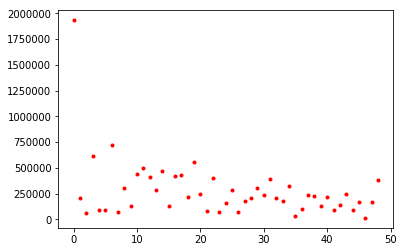

In [146]:
plt.plot(mi, 'r.')


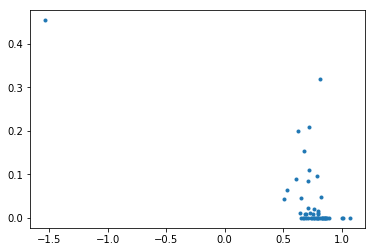

In [128]:
plt.plot(np.real(-mxll[ix,iy,0:80]), np.real(mi[0:80]/hy[0:80]), '.')
#plt.plot(-mxll[ix,iy,0:60])

In [ ]:
plt.plot(-np.diff(fluo[ix,iy,:,0]), 'r.')
plt.plot(-np.diff(fluo[ix,iy,:,1]), 'b.')

plt.plot(-np.diff(fluo[20,30,:,0]), 'rx')
plt.plot(-np.diff(fluo[20,30,:,1]), 'bx')

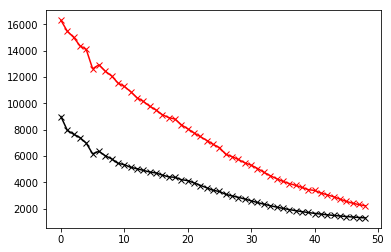

In [183]:
import scipy
from scipy.interpolate import UnivariateSpline

t = np.arange(0,nt)

ff1 = fluo[13,18,:,0]
tt1 = t[ff1>0]
ff1 = ff1[ff1>0]
spl1 = UnivariateSpline(tt1, ff1, s=1e4)
plt.plot(tt1,ff1, 'rx')
plt.plot(tt1,spl1(tt1), 'r')

ff1 = fluo[14,18,:,0]
tt1 = t[ff1>0]
ff1 = ff1[ff1>0]
spl1 = UnivariateSpline(tt1, ff1, s=1e4)
plt.plot(tt1,ff1, 'kx')
plt.plot(tt1,spl1(tt1), 'k')

In [138]:
from scipy.optimize import curve_fit

def exp_growth(x, a0, mu):
    #a0 = p[0]
    #mu = p[1]
    return a0*np.exp(mu*x)

popt1, pcov1 = curve_fit(exp_growth, tt1, spl1(tt1), p0=[1,1e-3])
popt2, pcov2 = curve_fit(exp_growth, tt2, spl2(tt2), p0=[1,1e-3])

In [139]:
popt1, popt2

(array([1.14986207e+02, 3.44861961e-02]),
 array([1.26118198e+02, 2.58880426e-02]))

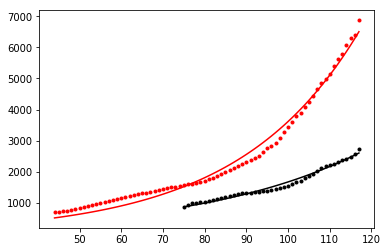

In [140]:
plt.plot(tt1, exp_growth(tt1, popt1[0], popt1[1]), 'r')
plt.plot(tt1,np.real(spl1(tt1)), 'r.')
plt.plot(tt2, exp_growth(tt2, popt2[0], popt2[1]), 'k')
plt.plot(tt2,np.real(spl2(tt2)), 'k.')